## MIT-BIH  Arrhythmia Dataset

- Number of Samples: 109446
- Number of Categories: 5
- Sampling Frequency: 125Hz
- Data Source: Physionet's MIT-BIH Arrhythmia Dataset
- Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]
- Remark: All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188.
- The final element of each row denotes the class to which that example belongs.

# Xgboost when using ECG signals as inputs

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset

The shape of the mitbih_train is :  (87554, 188)
The shape of the mitbih_test is :  (21892, 188)
The last time value is :  1488.0


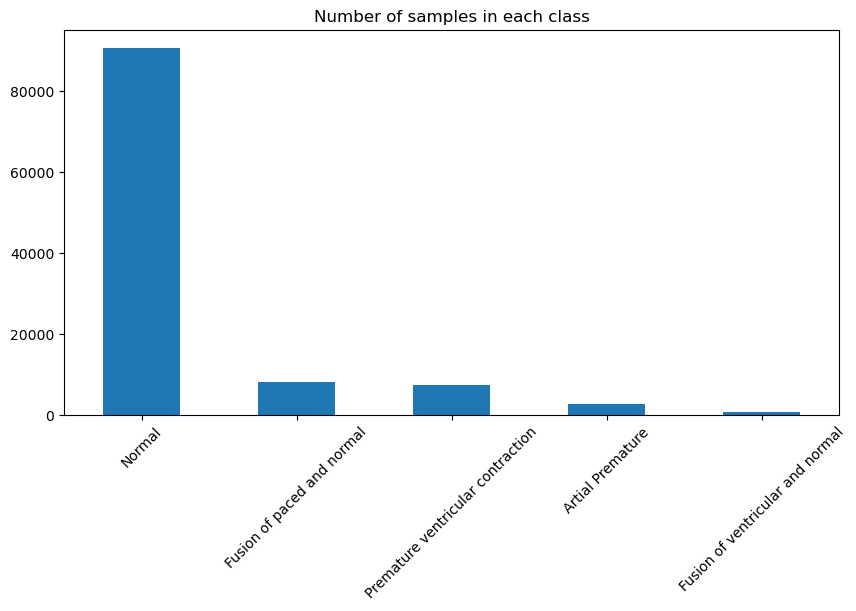

Normal                               90589
Fusion of paced and normal            8039
Premature ventricular contraction     7236
Artial Premature                      2779
Fusion of ventricular and normal       803
Name: label, dtype: int64

In [3]:
df_mitbih_train = pd.read_csv("../ecg_dataset/mitbih_train.csv", header = None)
df_mitbih_test = pd.read_csv("../ecg_dataset/mitbih_test.csv", header = None)

# print shapes of the dataframes
print("The shape of the mitbih_train is : ", df_mitbih_train.shape)
print("The shape of the mitbih_test is : ", df_mitbih_test.shape)

df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)
df_mitbih.rename(columns={187: 'label'}, inplace=True)

id_to_label = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}
#df_mitbih['label'] = df_mitbih.iloc[:, -1].map(id_to_label)

# get the number of columns in the dataframe
# the last column is the label/class
num_cols = df_mitbih.shape[1] - 1
# the signal was resampled at frequency of 125Hz as the input
# compute the time vector
time = np.arange(0, num_cols) / 125
# convert to milliseconds
time = time * 1000
# print last time value
print("The last time value is : ", time[-1])

# for the first "num_cols" and the time steps as column names
df_mitbih.columns = list(time) + ["label"]

# count the number of samples in each class and plot a bar chart
# change the class names to "normal" and "abnormal"
# count the number of samples in each class
counts = df_mitbih["label"].value_counts()
# substitute the class names
counts.index = counts.index.map(id_to_label)
# create a figure
plt.figure(figsize = (10, 5))
# plot a bar chart
counts.plot(kind = "bar")
# plot xticks in angle
plt.xticks(rotation = 45)
plt.title("Number of samples in each class")
plt.show()

counts

In [4]:
# Combine the datasets
df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)

# Rename the label column
df_mitbih.rename(columns={187: 'label'}, inplace=True)

# Print shapes of the combined dataframe
print("The shape of the combined mitbih dataframe is:", df_mitbih.shape)

The shape of the combined mitbih dataframe is: (109446, 188)


In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.model_selection import train_test_split
RANDOM_STATE=0

In [10]:
# Split data into training, validation, and test sets
X = df_mitbih.iloc[:, :-1]  # Features
y = df_mitbih['label']       # Labels

# First, split into train and temporary (validation + test) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.1, stratify=y, random_state=RANDOM_STATE)

# Then, split the temporary set into validation and test sets
X_cv, X_test, y_cv, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=RANDOM_STATE)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_cv.shape)
print("Test set shape:", X_test.shape)
X_train = scaler.fit_transform(X_train)
X_cv = scaler.transform(X_cv)
X_test = scaler.transform(X_test)

print(type(X_train), type(X_cv), type(X_test))
print(type(y_train), type(y_cv), type(y_test))

Training set shape: (98501, 187)
Validation set shape: (5472, 187)
Test set shape: (5473, 187)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [11]:
from sklearn.utils import resample

# Desired number of samples per class
target_samples = 8039 * 2

# Function to resample each class
def resample_class(X, y, target_samples, is_majority=False):
    if is_majority:
        return resample(X, y, replace=False, n_samples=target_samples, random_state=42)
    else:
        return resample(X, y, replace=True, n_samples=target_samples, random_state=42)

# Separate the classes
X_train_resampled = pd.DataFrame()
y_train_resampled = pd.Series(dtype='int')

for label in y_train.unique():
    # Filter the class-specific data
    X_class = X_train[y_train == label]
    y_class = y_train[y_train == label]
    
    # Resample the data
    if label == 0:  # Undersample the normal class to 8039*2
        X_res, y_res = resample_class(X_class, y_class, target_samples, is_majority=True)
    else:  # Oversample the other classes to 8039*2
        X_res, y_res = resample_class(X_class, y_class, target_samples, is_majority=False)
    
    # Convert to DataFrame/Series if necessary
    X_res = pd.DataFrame(X_res)
    y_res = pd.Series(y_res)
    
    # Combine the resampled data
    X_train_resampled = pd.concat([X_train_resampled, X_res], axis=0)
    y_train_resampled = pd.concat([y_train_resampled, y_res], axis=0)

# Shuffle the resampled training set
X_train_resampled, y_train_resampled = X_train_resampled.sample(frac=1, random_state=42).reset_index(drop=True), y_train_resampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Print the shape of the resampled training set
print("Resampled training set shape:", X_train_resampled.shape)
print("Resampled training labels shape:", y_train_resampled.shape)

X_train = X_train_resampled
y_train = y_train_resampled

Resampled training set shape: (80390, 187)
Resampled training labels shape: (80390,)


In [12]:
# Count the number of instances for each class in the resampled training dataset
class_counts = y_train.value_counts().sort_index()

# Map the class IDs to their corresponding labels
class_counts_named = class_counts.rename(index=id_to_label)

# Print the number of instances for each class
print("Number of instances for each class in the resampled training dataset:")
print(class_counts_named)


Number of instances for each class in the resampled training dataset:
Normal                               16078
Artial Premature                     16078
Premature ventricular contraction    16078
Fusion of ventricular and normal     16078
Fusion of paced and normal           16078
dtype: int64


In [13]:
# Convert to DataFrame if necessary (this might not be required if they are already DataFrames)
if not isinstance(X_train, pd.DataFrame):
    X_train = pd.DataFrame(X_train)
if not isinstance(X_cv, pd.DataFrame):
    X_cv = pd.DataFrame(X_cv)
if not isinstance(X_test, pd.DataFrame):
    X_test = pd.DataFrame(X_test)

print(type(X_train), type(X_cv), type(X_test))
print(type(y_train), type(y_cv), type(y_test))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


# Training Model Task 2


In [ ]:
import joblib
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

In [20]:
# Initialize the XGBClassifier with regularization and early stopping
xgb_model2 = XGBClassifier(n_estimators=500, learning_rate=0.1, max_depth=4,
                          reg_alpha=0.1, reg_lambda=0.1, subsample=0.8,
                          colsample_bytree=0.8, verbosity=0, early_stopping_rounds=50, random_state=RANDOM_STATE)

# Fit the model with early stopping
xgb_model2.fit(X_train, y_train,
              eval_set=[(X_cv, y_cv)],
              verbose=True)


# Evaluate the model
train_accuracy = accuracy_score(y_train, xgb_model2.predict(X_train))
test_accuracy = accuracy_score(y_test, xgb_model2.predict(X_test))

print(f"Metrics train:\n\tAccuracy score: {train_accuracy:.4f}")
print(f"Metrics test:\n\tAccuracy score: {test_accuracy:.4f}")



[0]	validation_0-mlogloss:1.50921
[1]	validation_0-mlogloss:1.42476
[2]	validation_0-mlogloss:1.34557
[3]	validation_0-mlogloss:1.27992
[4]	validation_0-mlogloss:1.22086
[5]	validation_0-mlogloss:1.17042
[6]	validation_0-mlogloss:1.12049
[7]	validation_0-mlogloss:1.07780
[8]	validation_0-mlogloss:1.03592
[9]	validation_0-mlogloss:0.99760
[10]	validation_0-mlogloss:0.96461
[11]	validation_0-mlogloss:0.93394
[12]	validation_0-mlogloss:0.90464
[13]	validation_0-mlogloss:0.87458
[14]	validation_0-mlogloss:0.84941
[15]	validation_0-mlogloss:0.82538
[16]	validation_0-mlogloss:0.80487
[17]	validation_0-mlogloss:0.78601
[18]	validation_0-mlogloss:0.76540
[19]	validation_0-mlogloss:0.74725
[20]	validation_0-mlogloss:0.73090
[21]	validation_0-mlogloss:0.71738
[22]	validation_0-mlogloss:0.70214
[23]	validation_0-mlogloss:0.68840
[24]	validation_0-mlogloss:0.67458
[25]	validation_0-mlogloss:0.66032
[26]	validation_0-mlogloss:0.64721
[27]	validation_0-mlogloss:0.63682
[28]	validation_0-mlogloss:0.6

[231]	validation_0-mlogloss:0.22931
[232]	validation_0-mlogloss:0.22862
[233]	validation_0-mlogloss:0.22784
[234]	validation_0-mlogloss:0.22720
[235]	validation_0-mlogloss:0.22658
[236]	validation_0-mlogloss:0.22621
[237]	validation_0-mlogloss:0.22550
[238]	validation_0-mlogloss:0.22494
[239]	validation_0-mlogloss:0.22441
[240]	validation_0-mlogloss:0.22381
[241]	validation_0-mlogloss:0.22339
[242]	validation_0-mlogloss:0.22291
[243]	validation_0-mlogloss:0.22222
[244]	validation_0-mlogloss:0.22160
[245]	validation_0-mlogloss:0.22097
[246]	validation_0-mlogloss:0.22041
[247]	validation_0-mlogloss:0.21984
[248]	validation_0-mlogloss:0.21937
[249]	validation_0-mlogloss:0.21890
[250]	validation_0-mlogloss:0.21816
[251]	validation_0-mlogloss:0.21762
[252]	validation_0-mlogloss:0.21705
[253]	validation_0-mlogloss:0.21670
[254]	validation_0-mlogloss:0.21616
[255]	validation_0-mlogloss:0.21533
[256]	validation_0-mlogloss:0.21478
[257]	validation_0-mlogloss:0.21396
[258]	validation_0-mlogloss:

[459]	validation_0-mlogloss:0.14275
[460]	validation_0-mlogloss:0.14247
[461]	validation_0-mlogloss:0.14221
[462]	validation_0-mlogloss:0.14197
[463]	validation_0-mlogloss:0.14173
[464]	validation_0-mlogloss:0.14151
[465]	validation_0-mlogloss:0.14138
[466]	validation_0-mlogloss:0.14108
[467]	validation_0-mlogloss:0.14085
[468]	validation_0-mlogloss:0.14069
[469]	validation_0-mlogloss:0.14043
[470]	validation_0-mlogloss:0.14027
[471]	validation_0-mlogloss:0.14011
[472]	validation_0-mlogloss:0.13995
[473]	validation_0-mlogloss:0.13969
[474]	validation_0-mlogloss:0.13952
[475]	validation_0-mlogloss:0.13924
[476]	validation_0-mlogloss:0.13904
[477]	validation_0-mlogloss:0.13873
[478]	validation_0-mlogloss:0.13856
[479]	validation_0-mlogloss:0.13851
[480]	validation_0-mlogloss:0.13824
[481]	validation_0-mlogloss:0.13809
[482]	validation_0-mlogloss:0.13780
[483]	validation_0-mlogloss:0.13764
[484]	validation_0-mlogloss:0.13733
[485]	validation_0-mlogloss:0.13713
[486]	validation_0-mlogloss:

['task2_1D_xgb_model500.pkl']

In [ ]:
# Save the model to a file
joblib.dump(xgb_model2, 'task2_1D_xgb_model500.pkl')

In [66]:
# Step 1: Load the saved model
xgb_model2 = joblib.load('task2_1D_xgb_model500.pkl')


# Step 3: Evaluate the loaded model
train_accuracy = accuracy_score(y_train, xgb_model2.predict(X_train))
cv_accuracy = accuracy_score(y_cv, xgb_model2.predict(X_cv))
test_accuracy = accuracy_score(y_test, xgb_model2.predict(X_test))

# Step 4: Print the accuracy for each dataset
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {cv_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Training Accuracy: 0.9971
Validation Accuracy: 0.9582
Test Accuracy: 0.9649



XGBOOST Evaluation

Classification Report (Test):
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      4530
         1.0       0.60      0.87      0.71       139
         2.0       0.87      0.96      0.91       362
         3.0       0.68      0.85      0.76        40
         4.0       0.96      0.99      0.97       402

    accuracy                           0.96      5473
   macro avg       0.82      0.93      0.87      5473
weighted avg       0.97      0.96      0.97      5473

Confusion Matrix (Test):
[[4383   77   45   11   14]
 [  16  121    2    0    0]
 [   7    1  346    4    4]
 [   1    1    4   34    0]
 [   1    1    2    1  397]]
Metrics train:
	Accuracy score: 0.9971
Metrics test:
	Accuracy score: 0.9649


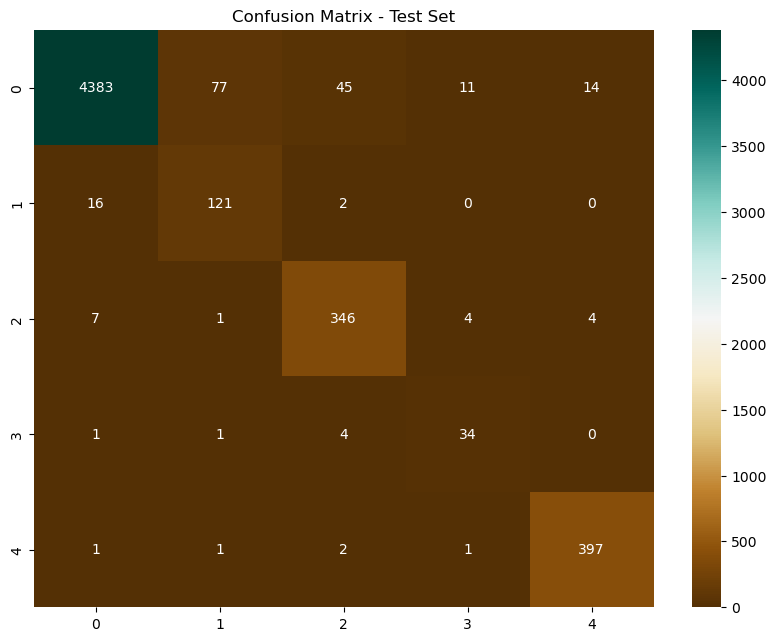

In [69]:
import seaborn as sns

# XGBoost Model Evaluation on Train and Test Data
print("\nXGBOOST Evaluation\n")

# Classification Report on Test Data
print("Classification Report (Test):")
print(classification_report(y_test, xgb_model2.predict(X_test)))

# Confusion Matrix on Test Data
print("Confusion Matrix (Test):")
conf_test = confusion_matrix(y_test, xgb_model2.predict(X_test))
print(conf_test)

# Accuracy Scores
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(xgb_model2.predict(X_train), y_train):.4f}")
print(f"Metrics test:\n\tAccuracy score: {accuracy_score(xgb_model2.predict(X_test), y_test):.4f}")


# Visualization for the Test Confusion Matrix
plt.figure(figsize=(10, 7.5))
sns.heatmap(conf_test, annot=True, cmap='BrBG', fmt='g')
plt.title("Confusion Matrix - Test Set")
plt.show()


# Xgboost when using GAF images as inputs

In [ ]:
# Define the shapes
total_samples_train = 80390  # Replace with the actual number of samples
flat_feature_size = 224 * 224  # Replace with the actual size of flattened features

# Load the memory-mapped arrays
X_train_flat = np.memmap('X_train_flat_memmap.dat', dtype='float32', mode='r+', shape=(total_samples_train, flat_feature_size))
y_train = np.memmap('y_train_memmap.dat', dtype='float32', mode='r+', shape=(total_samples_train,))

# Now you can use X_train_flat_memmap and y_train_memmap just like normal NumPy arrays
print("Memory-mapped files loaded successfully.")
print(f"Shape of X_train_flat_memmap: {X_train_flat.shape}")
print(f"Shape of y_train_memmap: {y_train.shape}")

In [ ]:
# Load X_test and y_test
X_test_flat = np.load('task2_X_test_flat.npy')
y_test = np.load('task2_y_test.npy')

print("X_test_flat and y_test have been loaded successfully.")
print(f"Shape of X_test_flat: {X_test_flat.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Load X_cv and y_cv
X_cv_flat = np.load('task2_X_cv_flat.npy')
y_cv = np.load('task2_y_cv.npy')

print("X_cv_flat and y_cv have been loaded successfully.")
print(f"Shape of X_cv_flat: {X_cv_flat.shape}")
print(f"Shape of y_cv: {y_cv.shape}")

In [ ]:
# Now you can use X_train_flat_memmap and y_train_memmap just like normal NumPy arrays
print("Memory-mapped files loaded successfully.")
print(f"Shape of X_train_flat_memmap: {X_train_flat.shape}")
print(f"Shape of y_train_memmap: {y_train.shape}")
print("X_test_flat and y_test have been loaded successfully.")
print(f"Shape of X_test_flat: {X_test_flat.shape}")
print(f"Shape of y_test: {y_test.shape}")
print("X_cv_flat and y_cv have been loaded successfully.")
print(f"Shape of X_cv_flat: {X_cv_flat.shape}")
print(f"Shape of y_cv: {y_cv.shape}")

In [ ]:
X_train_flat_small = X_train_flat[:1000]
y_train_small = y_train[:1000]

xgb_model2 = XGBClassifier(n_estimators=10, learning_rate=0.1, max_depth=4,
                          reg_alpha=0.1, reg_lambda=0.1, subsample=0.8,
                          colsample_bytree=0.8, verbosity=0, early_stopping_rounds=50, random_state=RANDOM_STATE)


xgb_model2.fit(X_train_flat_small, y_train_small,
              eval_set=[(X_cv_flat[:200], y_cv[:200])],
              verbose=True)


In [ ]:
# Step 5: Evaluate the Model
train_accuracy = accuracy_score(y_train[:200], xgb_model2.predict(X_train_flat[:200]))
cv_accuracy = accuracy_score(y_cv[:200], xgb_model2.predict(X_cv_flat[:200]))
test_accuracy = accuracy_score(y_test[:200], xgb_model2.predict(X_test_flat[:200]))

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {cv_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")